# Technical Lesson: Computer Vision with Convolutional Neural Networks

## Part 1: Libraries & Preprocessing the Data

### Step 1: Loading libraries

We'll start by loading some of the typical packages from `numpy`, `pandas`, and `sklearn`. Then we'll import a few of the necessary functions from `tensorflow` and `keras`.

These use the same classes and functions as we have seen before with a few new additions.
`Conv2D` is convolutional layers for 2-dimensional data such as images, and `MaxPooling2D` is a max-pooling layer.
We'll also use the `Flatten` layer which reshapes a 2-dimensional image into a vector.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# TensorFlow / Keras functions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

### Step 2: Load data


We'll use the MNIST handwritten image dataset for this exercise. This dataset consists of 70,000 images.
The following function downloads and loads the data as training and testing sets (60k, 10k).

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# dimensions
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


### Step 3: Training Set

Because the purpose of this lesson is to learn how to train CNNs and not to achieve the best digit classifier, we're going to use only a subset of the original data.
This will allow us to train models faster, and experiment with different structures.

The following code creates a new training set of only 10,000 images (1,000 for each digit) using the `train_test_split` function. Since we already have a test set, we'll just throw out the test set returned by this function. The underscores, `_`, tell Python not to assign the test sets to a variable.

In [3]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10000, 28, 28) (10000, 28, 28) (10000,) (10000,)


### Step 4: One-hot-encoded vectors

The last preprocessing step is to convert the response variable from a vector of digits, to a set of one-hot-encoded vectors for each digit. This is like creating dummy variables for each response variable, and is required to train multiclass classification models in TensorFlow.

For example if the digit is a "0" the response vector we will try to predict is actually [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

If it was a "3" we would try to predict [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [4]:
print('Example Y variable before transformation:', y_train[0])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('Example Y variable after transformation:', y_train[0])

Example Y variable before transformation: 6
Example Y variable after transformation: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### Step 5: 4-D Array

The last preprocessing step we need is make our images a 4 dimensional array: the 1st dimension is for the number of images, the 2nd and 3rd are for the width and height of the images, and the 4th is for the number of channels (1 for grayscale, 3 for color).

This is the required format for the convolutional layer.

In [5]:
# (number of images, width, height, depth)
X_train = X_train.reshape(10000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

## Part 2: Model 1

### Step 5: Model 1- CNN with 1 convolutional layer and 1 pooling layer

Let's fit a CNN with the folling structure
 - 1 convolutional layer with:
     - 16 filters (neurons)
     - a window size of 3
     - stride size of 1
     - ReLU activation function
     - padding so that the feature is the same size as the original image
 - 1 max pooling layer with:
     - window size of 2
     - stride size of 2
     - no padding
 - 1 fully connected output layer with:
     - 10 nodes for each digit to predict
     - softmax activation function

The following code creates this model using Keras

In [6]:
model1 = Sequential()
model1.add(Conv2D(16, kernel_size=3, activation='relu',
                 padding='same', input_shape=(28,28,1)))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model1.add(Flatten())
model1.add(Dense(10, activation='softmax'))

The `kernel_size` parameter specifies the filter or window size, and can be an integer like `3` or the actual window size like `(3,3)`. The `pool_size` is a similar parameter for the pooling layer. The `input_shape` tells the model the format of the images (width, height, depth). Depth is just 1 because these are grayscale images, but it would be 3 for color images (RGB).  

By specifying `padding='same'`, the output feature image will have the same size as the image passed to that layer. If we left this out, the default behavior returns a smaller image.

We used a `strides` parameter for the pooling layer, but by default it is 1.

The `Flatten` layer reshapes the image so that it is a flat vector to pass to the fully connected layer.

### Step 6: Summary

Next, let's print a summary of the model:

In [7]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 10)                31370     
                                                                 
Total params: 31,530
Trainable params: 31,530
Non-trainable params: 0
_________________________________________________________________


This shows that the convolutional layer has 160 parameters associated with it. There are 10 parameters for each of the 16 feature maps (neuron). There are 10 parameters for each feature map because there are 9 pixels in the filter (3x3) and an extra one for the bias.

Notice that there are no parameters that need to be learned for the pooling layer. This is because it simply applies an operation (max) to a set of pixels and returns the results.

Both the convolutional and pooling layers tell you the output shape, that is, the size of the image for the feature map.

Similarly, the flatten layer just rearranges the pixels for the final layer, so there are no parameters associated with it.

Finally, the fully connected layer (also the output layer) learns a weight for each of the pixels in the pooling layer (3136) plus a bias. This is done for each of the 10 classes (digits).  

### Step 7: Compile and fit

Next, we will compile and fit the model using the same steps we used for fully connected neural networks.  
We'll use a batch size of 256 with 10 epochs.

**N.B.: To keep this lesson simple, we're using the test set as a validation set. This is bad idea in practice, because we could overfit to the test set.**

In [8]:
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model1.fit(X_train, y_train, epochs=10, batch_size=256,
           validation_data=(X_test, y_test))
model1.evaluate(X_test, y_test)

Epoch 1/10
40/40 [==============================] - 2s 34ms/step - loss: 10.2959 - accuracy: 0.6605 - val_loss: 2.0788 - val_accuracy: 0.8738
Epoch 2/10
40/40 [==============================] - 1s 30ms/step - loss: 1.3903 - accuracy: 0.8974 - val_loss: 1.2525 - val_accuracy: 0.9103
Epoch 3/10
40/40 [==============================] - 1s 28ms/step - loss: 0.6589 - accuracy: 0.9371 - val_loss: 0.8567 - val_accuracy: 0.9269
Epoch 4/10
40/40 [==============================] - 1s 27ms/step - loss: 0.4003 - accuracy: 0.9511 - val_loss: 0.6697 - val_accuracy: 0.9381
Epoch 5/10
40/40 [==============================] - 1s 26ms/step - loss: 0.2203 - accuracy: 0.9679 - val_loss: 0.6325 - val_accuracy: 0.9370
Epoch 6/10
40/40 [==============================] - 1s 27ms/step - loss: 0.1511 - accuracy: 0.9724 - val_loss: 0.6323 - val_accuracy: 0.9370
Epoch 7/10
40/40 [==============================] - 1s 29ms/step - loss: 0.1209 - accuracy: 0.9744 - val_loss: 0.5245 - val_accuracy: 0.9452
Epoch 8/10
4

[0.4859321415424347, 0.9488999843597412]

### Step 8: Plot feature maps

One advantage of using CNNs for image data is the ability to examine how the network is representing features of the images.  
We can take an example from our dataset and see how the convolutional and pooling creates feature maps.  

Here is an example image:

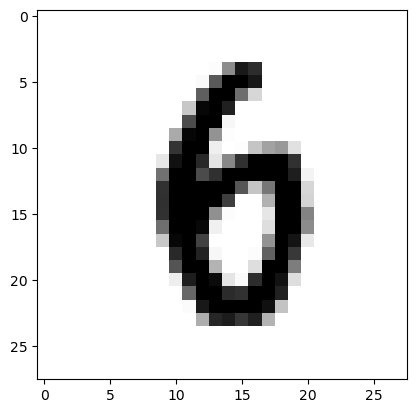

In [9]:
# An example that we'll explore
img_index = 0
example = X_train[img_index, :, :, 0].reshape(28, 28)

plt.imshow(example, plt.cm.binary)

### Step 9: Predictions

Before we can plot the features maps, we need to extract the outputs from each layer of the network.

We can get this by creating a model from the trained layers, and getting predictions for each layer.

In [10]:
# Create list of layer outputs
layer_outputs = [layer.output for layer in model1.layers]

# Create a model that will return the outputs at each layer
layers_model = keras.Model(inputs=model1.layers[0].input, outputs=layer_outputs)

# Get predictions for each layer of the network
outputs = layers_model.predict(example.reshape(1, 28, 28, 1))
conv_output = outputs[0]
pooling_output = outputs[1]

1/1 [==============================] - 0s 129ms/step


### Step 10: Feature Maps (first convolution layer)

Now let's plot the 16 feature maps from the first convolutional layer.

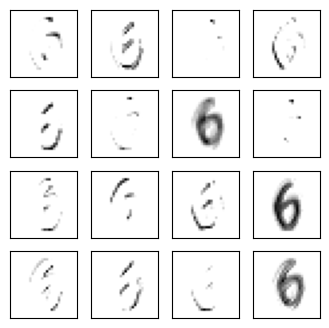

In [11]:
# 16 feature maps
def PlotFeatureMaps(output_predictions):
    """ This plots the features maps from the output of either a
        convolutional or pooling layer with 16 feature maps (neurons).

        output_predictions should be a 4 dimensional array of predictions from a layer.
        The first dimension should be 1 (it's just a single image).
        The last dimension is for the indices of the feature maps (0-15).
    """
    n_col = 4
    n_row = 4
    plt.figure(figsize=(n_col, n_row))
    for j in range(n_row * n_col):
        plt.subplot(n_row, n_col, j + 1)
        plt.imshow(output_predictions[0, :, :, j], cmap=plt.cm.binary)
        plt.xticks(())
        plt.yticks(())
    plt.show
    return None

PlotFeatureMaps(conv_output)

### Step 11: Feature Maps (first pooling layer)

Here are the 16 feature maps from the first pooling layer. Notice how they are the same images from the convolutional layer, but are condensed and smaller versions.

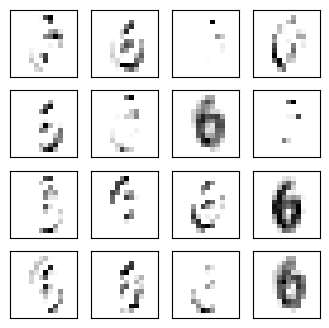

In [12]:
PlotFeatureMaps(pooling_output)